In [6]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from superrad import ultralight_boson as ub

#orig_path= "/Users/sebhoof/Research/BHSR/"
#sys.path.append("../code_matt/")
#from BH_functions import stellar_functions

from py.plotting import *
from py.constants import *
from py.bhsr import *
from py.bosenova import *

!mkdir -p figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Compare BHSR rates

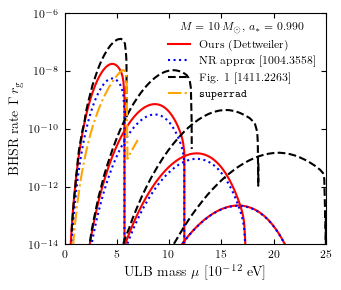

In [3]:
states = [(ell+1, ell, ell) for ell in range(1,6)]
astar0 = 0.99
mbh0 = 10.0

masha_bhsr_rates = []
for i in range(1,5):
    data = np.genfromtxt("data/1411_2263/ell_{:d}".format(i))
    masha_bhsr_rates.append(data)

muvals_small = np.linspace(0.01, 7, 200)*1e-12
muvals = np.linspace(0.01, 25, 250)*1e-12
bc = ub.UltralightBoson(spin=0, model="relativistic")
superrad_bhsr_rates = [GammaSR_nlm_superrad(mu, mbh0, astar0, bc)*rg(mbh0) for mu in muvals_small]
for s in states:
    n, l, m = s
    p0 = plt.plot(muvals/1e-12, GammaSR_nlm_mod(muvals, mbh0, astar0, n, l, m)*rg(mbh0), 'r', label=r"Ours (Dettweiler)")
    p1 = plt.plot(muvals/1e-12, GammaSR_nlm_nr(muvals, mbh0, astar0, n, l, m)*rg(mbh0), 'b:', label=r"NR approx [1004.3558]")
for d in masha_bhsr_rates:
    p2 = plt.plot(d[:,0]/1e-12, d[:,1], 'k--', label=r"Fig. 1 [1411.2263]")
p3 = plt.plot(muvals_small/1e-12, superrad_bhsr_rates, c='orange', ls='-.', label=r"\texttt{superrad}")
plt.legend(handles=p0+p1+p2+p3, title=r"$M = {:.0f}\,M_\odot$, $a_\ast = {:.3f}$".format(mbh0, astar0))
plt.xlabel(r"ULB mass $\mu$ [$10^{-12}$ eV]")
plt.ylabel(r"BHSR rate $\Gamma\,r_\text{g}$")
plt.xlim([0, 25])
plt.ylim([1e-14, 1e-6])
plt.yscale('log')
plt.savefig("figures/rate_comparison.pdf", backend='pgf')
plt.show()

### Plot some Regge slopes for our BHSR rates

In [10]:
ma_test = 7e-12
states = np.array([(i,j,j) for i in range(7) for j in range(1,i)])

# Compute Regge slopes for our SR rate approx and many states

m_bh_vals = np.arange(-1, 2, 0.02)
ma0 = 4.3e-12
a_vals_2 = compute_regge_slopes(ma0, 10**m_bh_vals, states)
approx_regge_slope = interp1d(m_bh_vals, [np.nanmin(a) for a in a_vals_2])

foo = lambda mu, mbh, a: GammaSR_nlm_superrad(mu, mbh, a)
a_vals_3 = compute_regge_slopes_given_rate(ma0, 10**m_bh_vals, foo)

# Compare to the final spin from superrad
# N.B. Superrad evolves the spin until there is 1 boson left in the cloud!
# This can leads to an evolution over time scales longer than the age of the BH etc.

a_vals_4 = []
bc = ub.UltralightBoson(spin=0, model="relativistic")
for mbh in 10**m_bh_vals:
   try:
      wf = bc.make_waveform(mbh, 0.99, ma0, units="physical")
      a_vals_4.append(wf.spin_bh_final())
   except:
      a_vals_4.append(np.nan)

/var/folders/7r/yf1l13xd5_7_hfd1dr2jvyfc0000gn/T/ipykernel_42055/2688709824.py:9: RuntimeWarning: All-NaN slice encountered
  approx_regge_slope = interp1d(m_bh_vals, [np.nanmin(a) for a in a_vals_2])


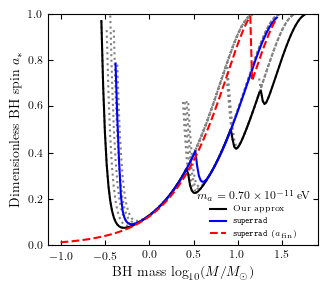

In [11]:
cond = (m_bh_vals > 0)

fig, ax = plt.subplots()

for i,s in enumerate(states):
    p1 = ax.plot(m_bh_vals, a_vals_2[:,i], c='gray', ls=':') #, label='$|{:d}{:d}{:d}\\rangle$'.format(*s))
p1 = ax.plot(m_bh_vals, approx_regge_slope(m_bh_vals), c='k', ls='-', label='Our approx')
p2 = ax.plot(m_bh_vals, a_vals_3, c='blue', lw=1.5, label=r"\texttt{superrad}")
p3 = ax.plot(m_bh_vals, a_vals_4, c='red', lw=1.5, ls='--', label=r"\texttt{superrad} ($a_\mathrm{fin}$)")

ax.set_xlabel('BH mass $\log_{10}(M/M_\odot)$')
ax.set_ylabel('Dimensionless BH spin $a_*$')
ax.set_ylim([0,1])
#ax.set_xlim([-1,2])

leg = ax.legend(handles=p1+p2+p3, frameon=False, loc=4, title='$m_a = {}\,$eV'.format(sci_format(ma_test)), fontsize=6)
#leg.get_title().set_fontsize('8')

fig.tight_layout()
fig.savefig("figures/regge_slope.pdf", dpi=300, backend='pgf')
plt.show()